In [34]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [ ]:
np.random.seed(0)
n_samples = 1500

# Make a large circle containing a smaller circle in 2d.
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# Make two interleaving half circles
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# Generate isotropic Gaussian blobs for clustering.
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# [0,1]均匀分布随意样本
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

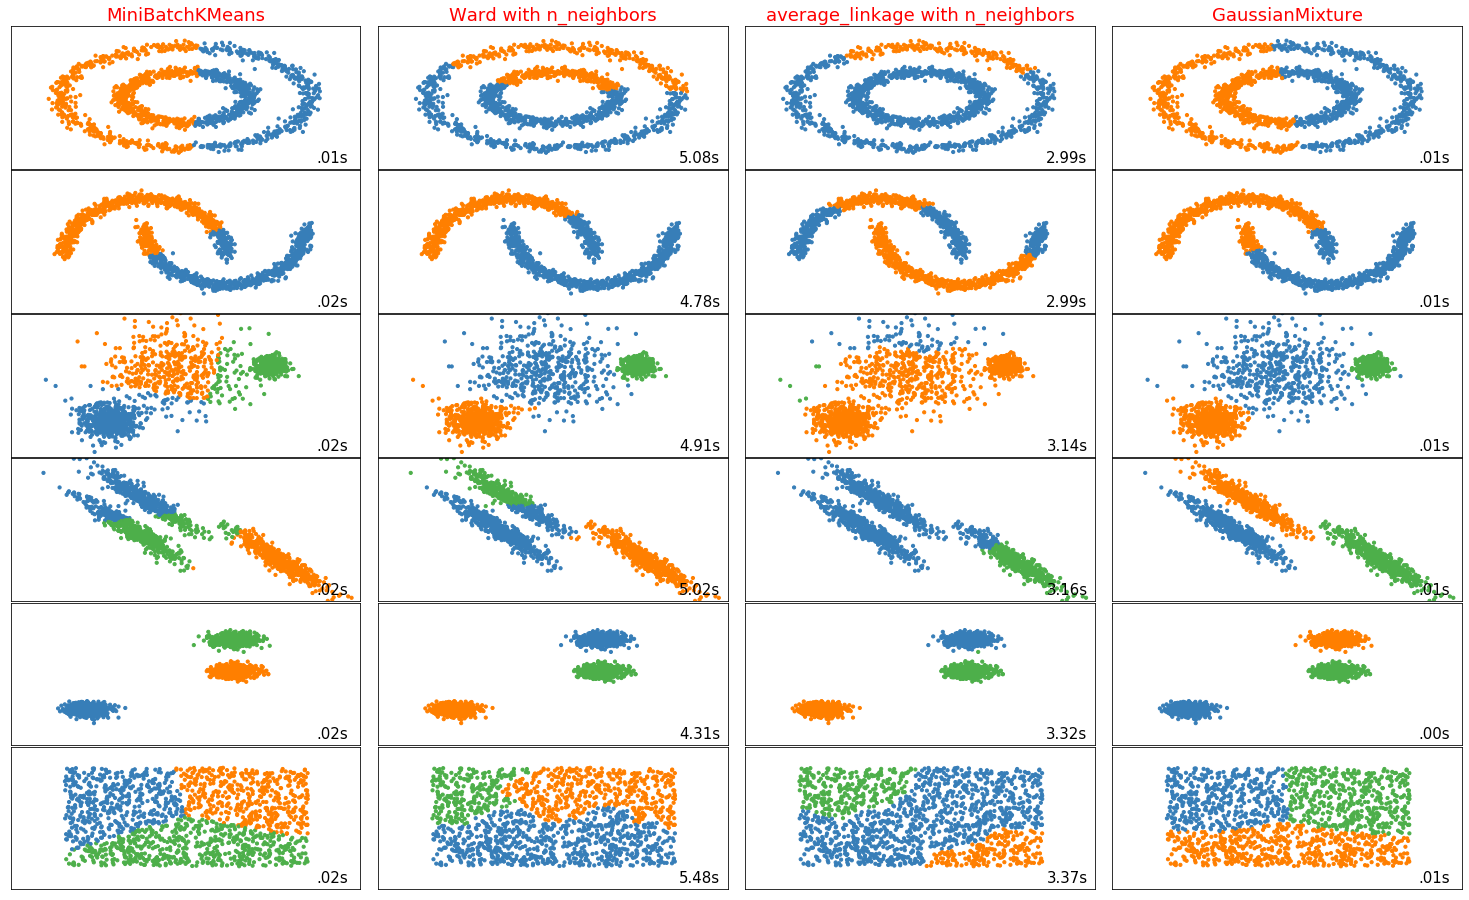

In [35]:
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_clusters': 3,  # 设置默认聚类簇数为3
                'n_neighbors': 500}  # Number of neighbors for each sample.

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {}),
    (aniso, {}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)  # 更新参数字典params

    X, y = dataset

    X = StandardScaler().fit_transform(X)  # 对X进行均值方差归一化处理

    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)  # 最邻近距离计算

    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])  # 小批量K近邻聚类
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)  # 层次聚类(linkage='ward', 此时必须arrinity='euclidean')
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", n_clusters=params['n_clusters'], affinity='manhattan',
        connectivity=connectivity)  # 层次聚类(linkage='average')
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')  # 高斯混合模型

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('Ward with n_neighbors', ward),
        ('average_linkage with n_neighbors', average_linkage),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()  # 获取fit函数运行时间

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18, color='red')

        colors = np.array(list(
            islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                          '#f781bf', '#a65628', '#984ea3',
                          '#999999', '#e41a1c', '#dede00']),  # 生成器切片
                   int(max(y_pred) + 1))))
        colors = np.append(colors, ["#000000"])

        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(2.1, -2.1, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 ha='center', size=15,
                 va='center')
        plot_num += 1

plt.show()
